In [95]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [96]:
class LSTM(nn.Module):
    def __init__(self, params):
        super(LSTM, self).__init__()
        self.input_size   = params['input_size']
        self.num_layers   = params['num_layers']
        self.hidden_size  = params['hidden_size']
        self.future_steps = params['future_steps']
        self.batch_size   = params['batch_size']

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc   = nn.Linear(self.hidden_size, self.input_size)  # Adjust the output size

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [97]:
class TrajectoryDataset(Dataset):
    def __init__(self, data, seq_len, future_steps, scaler=None, fit_scaler=False):
        self.data = data
        self.scaler = scaler
        self.seq_len = seq_len
        self.future_steps = future_steps
        
        if fit_scaler:
            self.fit_scaler()

        self.norm_data = self.normalize_data(self.data[['LA', 'LO', 'SOG','COG']])
    def fit_scaler(self):
        if self.scaler is not None:
            # Fit the scaler on the entire dataset
            # Adjust this based on your specific features
            self.scaler.fit(self.data[['LA', 'LO', 'SOG']])

    def normalize_data(self, df):
        norm_df = df.copy()
        if self.scaler is not None:
            # Normalize the relevant columns
            norm_df[['LA', 'LO', 'SOG']] = self.scaler.transform(df[['LA', 'LO', 'SOG']])
        # Additional normalization or feature engineering can be added here
            norm_df['COG'] = (np.sin(np.radians(df['COG'])) + 1) / 2
        return norm_df.to_numpy()

    def __len__(self):
        return len(self.data) - self.seq_len - self.future_steps + 1

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = start_idx + self.seq_len
        future_end_idx = end_idx + self.future_steps

        seq_data = self.norm_data[start_idx:end_idx]
        future_data = self.norm_data[end_idx]

        # Convert to PyTorch tensors
        seq_data = torch.tensor(seq_data, dtype=torch.float32)
        future_data = torch.tensor(future_data, dtype=torch.float32)

        return seq_data, future_data

In [98]:
SHIP_TYPE = 'TANK'
DIR       = f"/SNU/KRISO/data/resample_GMT_{SHIP_TYPE}_1T.csv"

data = pd.read_csv(DIR, dtype={'SHIP_ID':str}).sort_values('datetime').reset_index(drop=True)
data = data[['datetime', 'SHIP_ID', 'LA', 'LO', 'SOG', 'COG']]

print("Data Loaded")

Data Loaded


In [99]:
target_ship_id = 'urn:mrn:kor:vessel:officialno:BSR-210019'
filtered_data  = data[data['SHIP_ID'] == target_ship_id].reset_index(drop=True)

print(filtered_data.head())

              datetime                                   SHIP_ID         LA  \
0  2022-11-01 00:00:00  urn:mrn:kor:vessel:officialno:BSR-210019  36.567471   
1  2022-11-01 00:01:00  urn:mrn:kor:vessel:officialno:BSR-210019  36.569992   
2  2022-11-01 00:02:00  urn:mrn:kor:vessel:officialno:BSR-210019  36.572510   
3  2022-11-01 00:03:00  urn:mrn:kor:vessel:officialno:BSR-210019  36.575016   
4  2022-11-01 00:04:00  urn:mrn:kor:vessel:officialno:BSR-210019  36.577496   

           LO       SOG  COG  
0  125.935837  9.102873  8.0  
1  125.936302  9.077619  9.0  
2  125.936737  9.028023  7.0  
3  125.937164  9.088398  7.0  
4  125.937653  9.168329  6.0  


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device} is ready')

cuda is ready


In [101]:
params = {
    'scaler' : MinMaxScaler(),
    'seq_len' : 100,
    'input_size' : 4,
    'hidden_size' : 64,
    'num_layers' : 2,
    'output_size' : 4,
    'batch_size' : 128,
    'batch_shuffle': True,
    'num_epochs' : 20,
    'past_steps' : 100,
    'future_steps' : 180
    }

In [102]:
learning_rate = 0.001
model         = LSTM(params)
criterion     = nn.MSELoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler        = MinMaxScaler()

In [103]:
train_size      = int(len(filtered_data) * 0.6)
validation_size = int(len(filtered_data) * 0.2)
test_size       = len(filtered_data) - train_size - validation_size

train = filtered_data[:train_size]
valid = filtered_data[train_size:train_size+validation_size]
test  = filtered_data[train_size+validation_size:]

In [104]:
train_dataset = TrajectoryDataset(train, params['seq_len'], params['future_steps'], scaler=scaler, fit_scaler=True)
valid_dataset = TrajectoryDataset(valid, params['seq_len'], params['future_steps'], scaler=scaler, fit_scaler=False)

train_loader  = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=params['batch_shuffle'])
valid_loader  = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False)

In [105]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, params):
    model = model.to(device)
    model.train()

    num_epochs = params['num_epochs']

    for epoch in range(num_epochs):
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item() * inputs.size(0)

        valid_loss = valid_loss / len(valid_loader.dataset)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        model.train()

In [106]:
train_model(model, train_loader, valid_loader, criterion, optimizer, device, params)

Epoch 1: Train Loss: 0.0374, Validation Loss: 0.0007
Epoch 2: Train Loss: 0.0010, Validation Loss: 0.0004
Epoch 3: Train Loss: 0.0008, Validation Loss: 0.0004
Epoch 4: Train Loss: 0.0007, Validation Loss: 0.0003
Epoch 5: Train Loss: 0.0006, Validation Loss: 0.0004
Epoch 6: Train Loss: 0.0006, Validation Loss: 0.0002
Epoch 7: Train Loss: 0.0005, Validation Loss: 0.0003
Epoch 8: Train Loss: 0.0005, Validation Loss: 0.0002
Epoch 9: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 10: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 11: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 12: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 13: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 14: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 15: Train Loss: 0.0004, Validation Loss: 0.0001
Epoch 16: Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 17: Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 18: Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 19: Train Loss: 0.0003, Validat

In [107]:
test_dataset = TrajectoryDataset(test, params['seq_len'], params['future_steps'], scaler=scaler, fit_scaler=False)
test_loader  = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

In [113]:
def evaluate_model(model, test_loader, criterion, scaler, device):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')

    all_predictions_scaled = np.array(all_predictions)[:, :3]
    all_targets_scaled     = np.array(all_targets)[:, :3]

    all_predictions_scaled = scaler.inverse_transform(all_predictions_scaled)
    all_targets_scaled     = scaler.inverse_transform(all_targets_scaled)

    all_predictions = np.concatenate([all_predictions_scaled, np.array(all_predictions)[:, 3:]], axis=1)
    all_targets = np.concatenate([all_targets_scaled, np.array(all_targets)[:, 3:]], axis=1)

    return all_predictions, all_targets

In [114]:
all_predictions, all_targets = evaluate_model(model, test_loader, criterion, scaler, device)

Test Loss: 0.0002


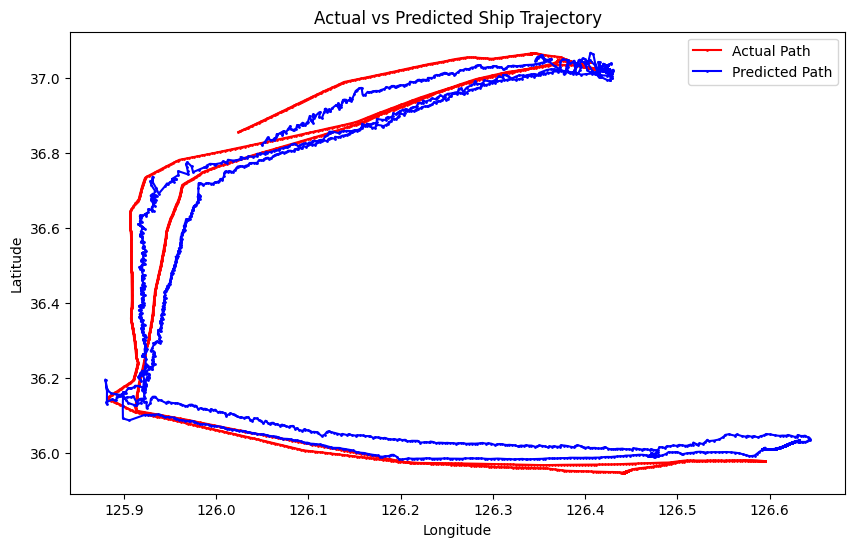

In [116]:
plt.figure(figsize=(10, 6))

plt.plot([x[1] for x in all_targets], [x[0] for x in all_targets], 'ro-', label='Actual Path', markersize=1)
plt.plot([x[1] for x in all_predictions], [x[0] for x in all_predictions], 'bo-', label='Predicted Path', markersize=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Ship Trajectory')
plt.legend()
plt.show()